In [1]:
import misc
import matplotlib as mpl
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, mannwhitneyu
from collections import defaultdict
import matplotlib.pyplot as plt
import yaml
import sys

from misc import rename_cytokines, rename_CMs, rename_bloods, rename_factors, rename_Y, make_annot, convert_partial_year, rename_pathways
from misc import pval_col, padj_col, coef_col, VISIT_TO_DAYS
import bcg_utils as utils

%load_ext autoreload
%autoreload 1
%aimport misc
%aimport bcg_utils
%aimport bcg_colors

from bcg_colors import *

In [2]:
_ = utils.setup_plotting(style='ticks', context='notebook', font_scale=1, rc=RC_PAPER)

FIG_SIZE = (1.25, 1.25)
HEATMAP_SIZE = (0.3, 0.3)
CIRCLE_SIZE = 20
CIRCLE_LINE_WIDTH = 0.4
ALPHA = 0.8
LGD_MARKER_SCALE = 1.2

FDR = [0.05]
ATAC_FDR = [0.1]
VOLCANO_MAX_ANNOT = 20
CELL_SIZE = 0.13
ENR_VMAX = 7
ENR_VMIN = -1 * ENR_VMAX
LOLA_VMAX = 150
LOLA_VMIN = -1 * LOLA_VMAX
LM_VMAX = 5
LM_VMIN = -1 * LM_VMAX
TRANSPOSE_ENR_TABLE = True
ENR_FIG_WIDTH, ENR_CELL_HEIGHT = (3, 0.15) if TRANSPOSE_ENR_TABLE else (10, 0.1)
PVAL_ASTERISKS = [0.05, 0.01, 0.001]
CORR_CBAR_KWS = dict(shrink=2, aspect=0.15, orientation='horizontal')

SAVE_FIG = True
fig_dir = utils.make_dir('results', 'figures', 'Figure5')
CELLTYPE = 'PBMC'
TOP_N = 1000
RANK_METRIC = 'p.value'

EXCLUDE = r'C\.albicans\.yeast_24h_PBMC_IFNg|lactate'

# Suppl. Tables

In [3]:
SAVE_TABLES = True
if SAVE_TABLES:
    suppl_tables = misc.get_container_with_tables([ATAC_V2_V3, ENRICH_V2_V3, ATAC_V2_V3_FULL, ENRICH_V2_V3_PROMOTERS, ENRICH_V2_V3_LOLA])

In [4]:
MODEL = 'fixed.donor_as_mixed.batch_corrected.sex.age.blood.TSS_enr.visit_time.season_interaction'

V2
Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
SEASON.V2: number of regions with <= FDR 0.05: 16949
Fitted seasonal effects (FDR 0.05): (244, 16949)


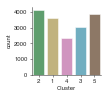

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
Peak month for cluster 1 (3596 regions): Mar
Peak month for cluster 2 (4123 regions): Feb
Peak month for cluster 3 (3050 regions): Nov
Peak month for cluster 4 (2323 regions): Jul
Peak month for cluster 5 (3857 regions): Sep


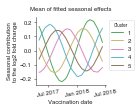

,Coefficient (cosine),Coefficient (sine),F-value,P-value,Adjusted P-value,Cluster,Promoter mapping,Distal mapping
Region,,,,,,,,
chr16_89872810_89874821,0.167443,0.073384,27.721588,2.440795e-12,1.258586e-07,2,TCF25,TCF25
chr19_703395_704579,0.233044,0.012016,26.830679,5.593537e-12,1.258586e-07,2,NaN,PALM
chr12_10212108_10214233,0.032729,-0.139380,26.752824,5.893635e-12,1.258586e-07,3,GABARAPL1,GABARAPL1
chr19_14405735_14406645,0.215097,0.109036,25.705952,1.569669e-11,2.514022e-07,2,NaN,NaN
chr1_1919093_1919945,0.155202,0.133214,24.880707,3.403612e-11,4.361048e-07,2,TMEM52,TMEM52


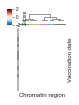

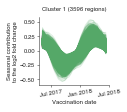

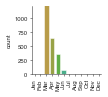

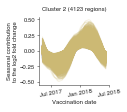

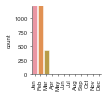

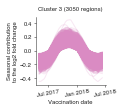

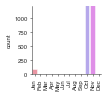

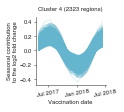

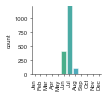

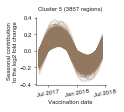

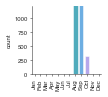

V3
Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
SEASON.V3: number of regions with <= FDR 0.05: 5787
Fitted seasonal effects (FDR 0.05): (237, 5787)


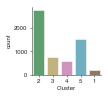

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
Peak month for cluster 1 (191 regions): Jun
Peak month for cluster 2 (2740 regions): Aug
Peak month for cluster 3 (771 regions): Nov
Peak month for cluster 4 (577 regions): Jan
Peak month for cluster 5 (1508 regions): Mar


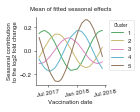

,Coefficient (cosine),Coefficient (sine),F-value,P-value,Adjusted P-value,Cluster,Promoter mapping,Distal mapping
Region,,,,,,,,
chr20_40688786_40690517,-0.144542,-0.211469,19.319642,6.749670e-09,0.000221,2,MAFB,MAFB
chr6_20402156_20404271,-0.097296,-0.182532,19.165603,7.812571e-09,0.000221,2,E2F3,E2F3
chr19_18416517_18419935,-0.014794,-0.169350,18.697276,1.210947e-08,0.000221,2,SSBP4,SSBP4
chr19_12789684_12790632,-0.055680,-0.155784,18.542350,1.378278e-08,0.000221,2,NaN,HOOK2
chr3_138914936_138916454,-0.087885,-0.116551,18.066663,2.156411e-08,0.000276,2,NaN,NaN


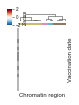

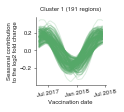

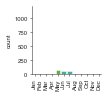

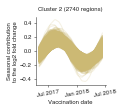

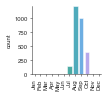

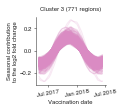

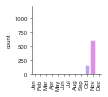

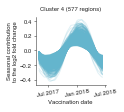

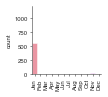

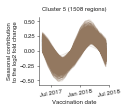

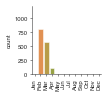

In [5]:
clust_palette = [GREEN, YELLOW, PINK, CYAN, BROWN, RED, BLUE, ORANGE, PURPLE]
clusters = {}

for visit, n_clusters, fig_n in [
    ('V2', 5, None),
    ('V3', 5, '5M'),
]:
    assert len(clust_palette) >= n_clusters
    print(visit)
    extras = f'_DONOR.IC_DATE_2PI_SIN.{visit}_{visit}.DONOR.IC_DATE_2PI_COS'
    coefs_df = pd.read_csv(misc.de_fn(CELLTYPE, MODEL, extras=extras), index_col=0)
    X_df = pd.read_csv(misc.de_fn(CELLTYPE, MODEL, data='design'), index_col=0)
    cos_coefs = coefs_df[misc.coef_col(f'{visit}.DONOR.IC_DATE_2PI_COS')].rename(f'{COEF_COL} (cosine)')
    sin_coefs = coefs_df[misc.coef_col(f'DONOR.IC_DATE_2PI_SIN.{visit}')].rename(f'{COEF_COL} (sine)')
    fitted_df = 0
    for c, coefs in [(f'{visit}.DONOR.IC_DATE_2PI_COS', cos_coefs),
                     (f'DONOR.IC_DATE_2PI_SIN.{visit}', sin_coefs)]:
        X = pd.DataFrame(data=np.broadcast_to(X_df[c], (len(coefs), len(X_df))).T, index=X_df.index, columns=coefs.index)
        fitted_df += X * coefs
    fitted_df = fitted_df.loc[fitted_df.index.str.contains(f'_{visit}_PBMC$')]

    df = misc.get_sample_annot()
    vacc_dates = df.loc[fitted_df.index, 'DONOR:IC_DATE_REAL'].sort_values()
    _first_vacc = 0.4
    _sort = vacc_dates % 1
    _sort.loc[_sort >= _first_vacc] -= 1
    vacc_dates = vacc_dates.iloc[np.argsort(_sort)]

    coef = f'SEASON.{visit}'
    de_df = misc.read_de(CELLTYPE, MODEL, contrasts=coef, F_test=True, annot_fn=misc.PEAK_ANNOT_ALL_FN)
    print(f'{coef}: number of regions with <= FDR {np.min(FDR)}: {(de_df[padj_col(coef)] <= np.min(FDR)).sum()}')

    # select the significant seasonal regions with a mask
    fitted_df = fitted_df[de_df.index].loc[vacc_dates.index, de_df[padj_col(coef)] < np.min(FDR)]
    print(f'Fitted seasonal effects (FDR {np.min(FDR)}): {fitted_df.shape}')
    
    # clustering
    cols_Z_fn = misc.de_fn(CELLTYPE, MODEL, data=f'cols_Z_{visit}', ext='npz', gzipped=False)
    data_for_cols_Z_fn = misc.de_fn(CELLTYPE, MODEL, data=f'data_for_cols_Z_{visit}')
    cols_Z = np.load(cols_Z_fn)['cols_Z']
    check_df = pd.read_csv(data_for_cols_Z_fn, index_col=0)
    assert ((check_df - fitted_df.T).abs() < 1e-6).all().all()
    clustering_fn = misc.de_fn(CELLTYPE, MODEL, data=f'clustering_{visit}')
    clusters = pd.read_csv(clustering_fn, index_col=0)[CLUSTER_COL]
#     de_df[CLUSTER_COL] = np.nan
    de_df.loc[clusters.index, CLUSTER_COL] = clusters
    de_df[CLUSTER_COL] = de_df[CLUSTER_COL].astype(pd.Int64Dtype())
    
    # number of regions per cluster
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    sns.countplot(de_df[CLUSTER_COL], palette=clust_palette)
    ax.set_xlabel(CLUSTER_COL)
    sns.despine()
    plt.show()
    
    # seasonal patterns
    peaks_df = misc.get_peak_annot()
    previous_xtick_dates = None
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    for clust, color in zip(np.unique(clusters), clust_palette):
        cluster_idx = clusters.index[clusters == clust]
        _sort = np.argsort(fitted_df.loc[:, cluster_idx].mean(axis=1))[::-1]
        peak_month = misc.convert_partial_year(vacc_dates.iloc[_sort][0]).date().strftime("%b")
        print(f'Peak month for cluster {clust} ({(clusters == clust).sum()} regions): {peak_month}')
        ax.plot(vacc_dates.sort_values(), fitted_df.loc[vacc_dates.sort_values().index, cluster_idx].mean(axis=1), label=clust, c=color)
        ax.set_title('Mean of fitted seasonal effects')
        ax.set_ylabel('Seasonal contribution\nto the log2 fold change')
        xtick_dates = [misc.convert_partial_year(xtick).date() for xtick in ax.get_xticks()]
        if previous_xtick_dates is None:
            previous_xtick_dates = xtick_dates
        else:
            assert [str(d) for d in xtick_dates] == [str(d) for d in previous_xtick_dates] 
    ax.set_xticklabels([d.strftime("%b %Y") for d in xtick_dates], rotation=10)
    ax.set_xlabel('Vaccination date')
    plt.legend(bbox_to_anchor=(1, 1), title=CLUSTER_COL)
    sns.despine()
    utils.savefig(os.path.join(fig_dir, f'atac_seasons_curves_{visit}.svg'), dpi=DPI)
    plt.show()
        
    if SAVE_TABLES:
        suppl_df = misc.suppl_table_atac_seq_LFC_season(de_df, cos_coefs, sin_coefs, visit, limit_FDR=np.min(FDR), suppl_tables=suppl_tables, table_name=ATAC_V2_V3, fig_n=fig_n)
        misc.suppl_table_atac_seq_LFC_season(de_df, cos_coefs, sin_coefs, visit, limit_FDR=None, suppl_tables=suppl_tables, table_name=ATAC_V2_V3_FULL, fig_n=fig_n[0] if fig_n is not None else None)
        display(suppl_df.head())
        
    # heatmap
    raster_heatmap = True
    clust_colors = {i + 1: c for i, c in enumerate(clust_palette)}
    col_colors = clusters.map(clust_colors)

    vacc_months = [misc.convert_partial_year(vacc_dates.loc[idx]).date().strftime('%b') for idx in fitted_df.index]
    vacc_months_order = [m for i, m in enumerate(vacc_months) if m != vacc_months[i-1]]
    month_colors = {m: c for m, c in zip(vacc_months_order, np.tile([LIGHT_GRAY, GRAY], 6))}
    row_colors = pd.Series(vacc_months, index=fitted_df.index).map(month_colors)

    cg = sns.clustermap(fitted_df, method='average', metric='correlation', row_cluster=False, col_linkage=cols_Z,
                        col_colors=col_colors, row_colors=row_colors, z_score=1,
                        yticklabels=False, xticklabels=False, dendrogram_ratio=0.1, vmin=-2, vmax=2,
                        cmap=utils.PALETTE_CODES['D'], figsize=FIG_SIZE, cbar_kws=dict(label='Z-score'))
    cg.ax_col_colors.set_yticks([])
    cg.ax_row_colors.set_xticks([])
    cg.ax_heatmap.set_xlabel('Chromatin region')
    cg.ax_heatmap.set_ylabel('Vaccination date')
    cg.cax.set_ylabel('Z-score', fontsize=SMALL_FONT)
    cg.cax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)

    if raster_heatmap:
        for heatmap_child in cg.ax_heatmap.get_children():
            if isinstance(heatmap_child, mpl.collections.QuadMesh):
                heatmap_child.set_rasterized(raster_heatmap)
        cg.ax_row_colors.set_rasterized(raster_heatmap)
        cg.ax_col_colors.set_rasterized(raster_heatmap)
    else:
        utils.clustermap_legend(ax=cg.ax_col_colors, color_codes=clust_colors, bbox_to_anchor=(1.3, 1), title=CLUSTER_COL, fontsize=SMALL_FONT)
        utils.clustermap_legend(ax=cg.ax_row_colors, color_codes=month_colors, bbox_to_anchor=(-0.5, 1), title='Month', fontsize=SMALL_FONT)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, f'atac_seasons_heatmap_{visit}.svg'), dpi=DPI)
    
    # all regions with curves overlapping
    for clust, color in zip(np.unique(clusters), clust_palette):
        peak_months = []
        previous_xtick_dates = None
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        for region in clusters.index[clusters == clust]:
            _sort = np.argsort(fitted_df[region])[::-1]
            peak_months.append(misc.convert_partial_year(vacc_dates.iloc[_sort][0]).date().strftime("%b"))
            ax.plot(vacc_dates.sort_values(), fitted_df.loc[vacc_dates.sort_values().index, region],
                    c=color, alpha=0.2, zorder=-10)
            ax.set_rasterization_zorder(0)
            ax.set_title(f'Cluster {clust} ({(clusters == clust).sum()} regions)')
            ax.set_ylabel('Seasonal contribution\nto the log2 fold change')
            xtick_dates = [misc.convert_partial_year(xtick).date() for xtick in ax.get_xticks()]
            if previous_xtick_dates is None:
                previous_xtick_dates = xtick_dates
            else:
                assert [str(d) for d in xtick_dates] == [str(d) for d in previous_xtick_dates] 

            ax.set_xticklabels([d.strftime("%b %Y") for d in xtick_dates], rotation=10)
            ax.set_xlabel('Vaccination date')
        sns.despine()
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, f'atac_seasons_cluster_{clust}_{visit}.svg'), dpi=DPI)
        plt.show()
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        sns.countplot(peak_months, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim((0, 1200))
        sns.despine()
        if SAVE_FIG:
            utils.savefig(os.path.join(fig_dir, f'atac_seasons_cluster_{clust}_peaks_{visit}.pdf'), dpi=DPI)
        plt.show()

Using this peak annotation: ../data/DE/peaks_filtered_PBMC.csv.gz
V2 enrichr GO_Biological_Process_2018 GENE_AND_DISTAL_10kb


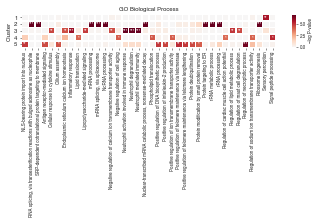

V2 enrichr KEGG_2019_Human GENE_AND_DISTAL_10kb


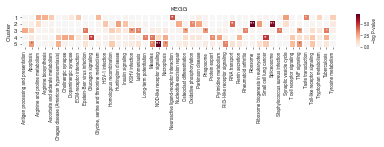

V3 enrichr KEGG_2019_Human GENE_AND_DISTAL_10kb


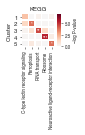

V3 enrichr GO_Biological_Process_2018 GENE_AND_DISTAL_10kb


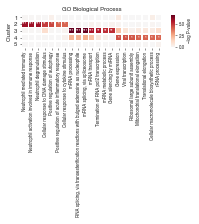

V2 enrichr GO_Biological_Process_2018 TSS_PROXIMAL


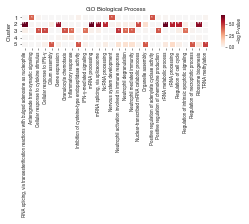

V2 enrichr KEGG_2019_Human TSS_PROXIMAL


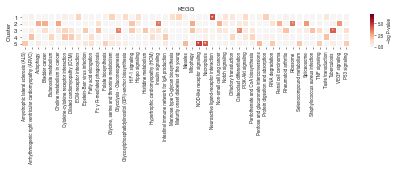

V3 enrichr GO_Biological_Process_2018 TSS_PROXIMAL


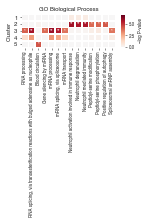

V3 enrichr KEGG_2019_Human TSS_PROXIMAL


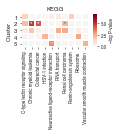

V2 lola HOCOMOCO_v11 None


/home/lfolkman/miniconda3/envs/BCG/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


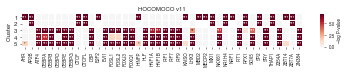

V3 lola HOCOMOCO_v11 None


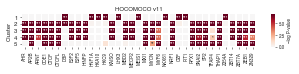

V2 lola Roadmap_Epigenomics_r9 None


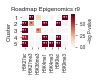

V3 lola Roadmap_Epigenomics_r9 None


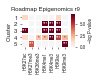

Odds ratio  \
Library                    Gene set                                           Cluster               
GO_Biological_Process_2018 rRNA metabolic process (GO:0016072)                2          3.791507   
                           mRNA processing (GO:0006397)                       2          3.237308   
                           ribosome biogenesis (GO:0042254)                   2          3.525344   
                           RNA splicing, via transesterification reactions... 2          3.288378   
                           rRNA processing (GO:0006364)                       2          3.479255   
...                                                                                           ...   
                           negative regulation of I-kappaB kinase-NF-kappa... 2          0.120262   
                           enzyme linked receptor protein signaling pathwa... 2          0.344944   
                           positive regulation of T cell activation (GO:00... 2          0.134055   
                           T cell activation (GO:0042110)                     2          0.198484   
                           antigen receptor-mediated signaling pathway (GO... 2          0.374125   

                                                                                            P-value  \
Library                    Gene set                                           Cluster                 
GO_Biological_Process_2018 rRNA metabolic process (GO:0016072)                2        7.242851e-17   
                           mRNA processing (GO:0006397)                       2        3.983044e-16   
                           ribosome biogenesis (GO:0042254)                   2        8.753842e-16   
                           RNA splicing, via transesterification reactions... 2        3.516752e-14   
                           rRNA processing (GO:0006364)                       2        3.974719e-14   
...                                                                                             ...   
                           negative regulation of I-kappaB kinase-NF-kappa... 2        9.999982e-01   
                           enzyme linked receptor protein signaling pathwa... 2        9.999998e-01   
                           positive regulation of T cell activation (GO:00... 2        9.999999e-01   
                           T cell activation (GO:0042110)                     2        1.000000e+00   
                           antigen receptor-mediated signaling pathway (GO... 2        1.000000e+00   

                                                                                       Adjusted P-value  \
Library                    Gene set                                           Cluster                     
GO_Biological_Process_2018 rRNA metabolic process (GO:0016072)                2            1.901248e-13   
                           mRNA processing (GO:0006397)                       2            5.227745e-13   
                           ribosome biogenesis (GO:0042254)                   2            7.659612e-13   
                           RNA splicing, via transesterification reactions... 2            2.086727e-11   
                           rRNA processing (GO:0006364)                       2            2.086727e-11   
...                                                                                                 ...   
                           negative regulation of I-kappaB kinase-NF-kappa... 2            1.000000e+00   
                           enzyme linked receptor protein signaling pathwa... 2            1.000000e+00   
                           positive regulation of T cell activation (GO:00... 2            1.000000e+00   
                           T cell activation (GO:0042110)                     2            1.000000e+00   
                           antigen receptor-mediated signaling pathway (GO... 2            1.000000e+00   

                                         

Odds ratio  \
Library                    Gene set                                           Cluster               
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3          5.172404   
                           RNA splicing, via transesterification reactions... 3          5.551152   
                           mRNA splicing, via spliceosome (GO:0000398)        3          4.952889   
                           mRNA transport (GO:0051028)                        3          5.147893   
                           neutrophil mediated immunity (GO:0002446)          2          1.663266   
...                                                                                           ...   
KEGG_2019_Human            T cell receptor signaling pathway                  5          0.127130   
                           Osteoclast differentiation                         5          0.121224   
                           Human cytomegalovirus infection                    5          0.215914   
                           Kaposi sarcoma-associated herpesvirus infection    5          0.093717   
                           Human immunodeficiency virus 1 infection           5          0.081407   

                                                                                            P-value  \
Library                    Gene set                                           Cluster                 
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3        1.986212e-11   
                           RNA splicing, via transesterification reactions... 3        5.624307e-11   
                           mRNA splicing, via spliceosome (GO:0000398)        3        2.347360e-10   
                           mRNA transport (GO:0051028)                        3        1.862176e-06   
                           neutrophil mediated immunity (GO:0002446)          2        1.045607e-06   
...                                                                                             ...   
KEGG_2019_Human            T cell receptor signaling pathway                  5        9.995841e-01   
                           Osteoclast differentiation                         5        9.997145e-01   
                           Human cytomegalovirus infection                    5        9.998795e-01   
                           Kaposi sarcoma-associated herpesvirus infection    5        9.999733e-01   
                           Human immunodeficiency virus 1 infection           5        9.999945e-01   

                                                                                       Adjusted P-value  \
Library                    Gene set                                           Cluster                     
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3            3.604975e-08   
                           RNA splicing, via transesterification reactions... 3            5.104059e-08   
                           mRNA splicing, via spliceosome (GO:0000398)        3            1.420153e-07   
                           mRNA transport (GO:0051028)                        3            8.449625e-04   
                           neutrophil mediated immunity (GO:0002446)          2            9.629465e-04   
...                                                                                                 ...   
KEGG_2019_Human            T cell receptor signaling pathway                  5            9.999945e-01   
                           Osteoclast differentiation                         5            9.999945e-01   
                           Human cytomegalovirus infection                    5            9.999945e-01   
                           Kaposi sarcoma-associated herpesvirus infection    5            9.999945e-01   
                           Human immunodeficiency virus 1 infection           5            9.999945e-01   

                                         

Odds ratio  \
Library                    Gene set                                           Cluster               
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       2          2.397448   
                           RNA splicing, via transesterification reactions... 2          2.438919   
                           rRNA metabolic process (GO:0016072)                2          2.659521   
                           ribosome biogenesis (GO:0042254)                   2          2.389258   
                           mRNA splicing, via spliceosome (GO:0000398)        2          2.227649   
...                                                                                           ...   
KEGG_2019_Human            Systemic lupus erythematosus                       2          0.189896   
                           Hematopoietic cell lineage                         2          0.145850   
                           Cell adhesion molecules (CAMs)                     2          0.242661   
                           Neuroactive ligand-receptor interaction            2          0.349248   
                           Cytokine-cytokine receptor interaction             2          0.276210   

                                                                                            P-value  \
Library                    Gene set                                           Cluster                 
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       2        1.297921e-08   
                           RNA splicing, via transesterification reactions... 2        7.934661e-08   
                           rRNA metabolic process (GO:0016072)                2        8.714405e-08   
                           ribosome biogenesis (GO:0042254)                   2        5.390640e-07   
                           mRNA splicing, via spliceosome (GO:0000398)        2        5.807030e-07   
...                                                                                             ...   
KEGG_2019_Human            Systemic lupus erythematosus                       2        9.999485e-01   
                           Hematopoietic cell lineage                         2        9.999587e-01   
                           Cell adhesion molecules (CAMs)                     2        9.999682e-01   
                           Neuroactive ligand-receptor interaction            2        9.999708e-01   
                           Cytokine-cytokine receptor interaction             2        9.999985e-01   

                                                                                       Adjusted P-value  \
Library                    Gene set                                           Cluster                     
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       2                0.000033   
                           RNA splicing, via transesterification reactions... 2                0.000074   
                           rRNA metabolic process (GO:0016072)                2                0.000074   
                           ribosome biogenesis (GO:0042254)                   2                0.000294   
                           mRNA splicing, via spliceosome (GO:0000398)        2                0.000294   
...                                                                                                 ...   
KEGG_2019_Human            Systemic lupus erythematosus                       2                0.999998   
                           Hematopoietic cell lineage                         2                0.999998   
                           Cell adhesion molecules (CAMs)                     2                0.999998   
                           Neuroactive ligand-receptor interaction            2                0.999998   
                           Cytokine-cytokine receptor interaction             2                0.999998   

                                         

Odds ratio  \
Library                    Gene set                                           Cluster               
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3          3.117497   
                           RNA splicing, via transesterification reactions... 3          3.299729   
                           mRNA splicing, via spliceosome (GO:0000398)        3          3.101257   
                           neutrophil activation involved in immune respon... 2          1.929134   
                           neutrophil mediated immunity (GO:0002446)          2          1.912415   
...                                                                                           ...   
                           RNA splicing (GO:0008380)                          2          0.098635   
KEGG_2019_Human            Cocaine addiction                                  2          0.198020   
                           Systemic lupus erythematosus                       2          0.225836   
                           Ribosome                                           2          0.184722   
                           Neuroactive ligand-receptor interaction            2          0.163012   

                                                                                        P-value  \
Library                    Gene set                                           Cluster             
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3        0.000001   
                           RNA splicing, via transesterification reactions... 3        0.000002   
                           mRNA splicing, via spliceosome (GO:0000398)        3        0.000003   
                           neutrophil activation involved in immune respon... 2        0.000001   
                           neutrophil mediated immunity (GO:0002446)          2        0.000002   
...                                                                                         ...   
                           RNA splicing (GO:0008380)                          2        0.999937   
KEGG_2019_Human            Cocaine addiction                                  2        0.992433   
                           Systemic lupus erythematosus                       2        0.998114   
                           Ribosome                                           2        0.999647   
                           Neuroactive ligand-receptor interaction            2        0.999996   

                                                                                       Adjusted P-value  \
Library                    Gene set                                           Cluster                     
GO_Biological_Process_2018 mRNA processing (GO:0006397)                       3                0.001311   
                           RNA splicing, via transesterification reactions... 3                0.001311   
                           mRNA splicing, via spliceosome (GO:0000398)        3                0.001524   
                           neutrophil activation involved in immune respon... 2                0.001539   
                           neutrophil mediated immunity (GO:0002446)          2                0.001539   
...                                                                                                 ...   
                           RNA splicing (GO:0008380)                          2                0.999937   
KEGG_2019_Human            Cocaine addiction                                  2                0.999996   
                           Systemic lupus erythematosus                       2                0.999996   
                           Ribosome                                           2                0.999996   
                           Neuroactive ligand-receptor interaction            2                0.999996   

                                                                                      Overlap

Odds ratio  P-value  \
Library                Region set Cluster                        
HOCOMOCO_v11           MBD2       2          7.789082      0.0   
                       MECP2      2          6.879985      0.0   
                       NRF1       2          6.114833      0.0   
                       E2F2       2          5.759482      0.0   
                       ZBT14      2          6.866496      0.0   
...                                               ...      ...   
Roadmap_Epigenomics_r9 H3K27me3   3          0.400595      1.0   
                                  4          0.318570      1.0   
                       H3K36me3   5          0.385181      1.0   
                       H3K27me3   5          0.264371      1.0   
                       H3K9me3    5          0.210184      1.0   

                                           Adjusted P-value     Overlap  
Library                Region set Cluster                                
HOCOMOCO_v11           MBD2       2                     0.0  3631/32793  
                       MECP2      2                     0.0  3595/33409  
                       NRF1       2                     0.0  3622/36096  
                       E2F2       2                     0.0  3505/33244  
                       ZBT14      2                     0.0  3335/26192  
...                                                     ...         ...  
Roadmap_Epigenomics_r9 H3K27me3   3                     1.0    172/8093  
                                  4                     1.0    105/8093  
                       H3K36me3   5                     1.0    174/6752  
                       H3K27me3   5                     1.0    149/8093  
                       H3K9me3    5                     1.0     20/1477  

[2040 rows x 4 columns]

Odds ratio        P-value  \
Library                Region set Cluster                              
Roadmap_Epigenomics_r9 H3K27ac    2          5.196322   0.000000e+00   
                       H3K4me3    3         79.553726  8.600992e-303   
                       H3K9me3    5         18.620328  2.567004e-282   
HOCOMOCO_v11           ZBT14      3         48.309046  2.411520e-255   
Roadmap_Epigenomics_r9 H3K27ac    3         17.867509  6.989153e-226   
...                                               ...            ...   
HOCOMOCO_v11           LHX3       5          0.604987   1.000000e+00   
Roadmap_Epigenomics_r9 H3K9ac     5          0.249798   1.000000e+00   
                       H3K4me1    5          0.242067   1.000000e+00   
                       H3K4me3    5          0.205131   1.000000e+00   
                       H3K27ac    5          0.145997   1.000000e+00   

                                           Adjusted P-value     Overlap  
Library                Region set Cluster                                
Roadmap_Epigenomics_r9 H3K27ac    2            0.000000e+00  2000/22982  
                       H3K4me3    3           6.020694e-302   754/23396  
                       H3K9me3    5           1.796903e-281    377/1477  
HOCOMOCO_v11           ZBT14      3           9.670193e-253   748/26192  
Roadmap_Epigenomics_r9 H3K27ac    3           2.446204e-225   699/22982  
...                                                     ...         ...  
HOCOMOCO_v11           LHX3       5            1.000000e+00   430/25287  
Roadmap_Epigenomics_r9 H3K9ac     5            1.000000e+00   356/34950  
                       H3K4me1    5            1.000000e+00   333/34072  
                       H3K4me3    5            1.000000e+00   163/23396  
                       H3K27ac    5            1.000000e+00   117/22982  

[2040 rows x 4 columns]

In [6]:
peaks_df = misc.get_peak_annot()
suppl_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: {})))
for visit, method, library, region_filter, pthw_fdr, pthw_max_n, force_index in [
    ('V2', 'enrichr', misc.GO_BIO_PROCESS, misc.GENE_AND_DISTAL_10kb, np.min(FDR), 10, None),
    ('V2', 'enrichr', misc.KEGG, misc.GENE_AND_DISTAL_10kb, None, 10, None),
    ('V3', 'enrichr', misc.KEGG, misc.GENE_AND_DISTAL_10kb, None, 1, 'fix_start'),
    ('V3', 'enrichr', misc.GO_BIO_PROCESS, misc.GENE_AND_DISTAL_10kb, np.min(FDR), 7, 'fix_start'),
    ('V2', 'enrichr', misc.GO_BIO_PROCESS, misc.TSS_PROXIMAL, np.min(FDR), 10, None),
    ('V2', 'enrichr', misc.KEGG, misc.TSS_PROXIMAL, None, 10, None),
    ('V3', 'enrichr', misc.GO_BIO_PROCESS, misc.TSS_PROXIMAL, np.min(FDR), 7, None),
    ('V3', 'enrichr', misc.KEGG, misc.TSS_PROXIMAL, None, 2, None),
    ('V2', 'lola', HOCOMOCO, None, None, 10, None),
    ('V3', 'lola', HOCOMOCO, None, None, 10, None),
    ('V2', 'lola', EPI_ROADMAP, None, None, 10, None),
    ('V3', 'lola', EPI_ROADMAP, None, None, 10, None),
]:
    print(visit, method, library, region_filter)
    coef = f'SEASON.{visit}'
    clustering_fn = misc.de_fn(CELLTYPE, MODEL, data=f'clustering_{visit}')
    clusters = pd.read_csv(clustering_fn, index_col=0)[CLUSTER_COL]
    de_df = misc.read_de(CELLTYPE, MODEL, contrasts=coef, F_test=True, peaks_df=peaks_df)
    
    terms = set()
    fix_start = []
    enr_df = {1: {}, -1: {}}
    for clust in np.unique(clusters):
        df = misc.read_enrichr_or_lola(
            celltype=None, model=None, coef=None, library=f'{library}_min15_max500' if method == 'enrichr' else library,
            effect_size_filter=None, rank_metric=None, top_n=None, region_filter=None, direction=None, method=method,
            filename=os.path.join(os.path.split(misc.de_fn(CELLTYPE, MODEL))[0], 'Enrichr' if method == 'enrichr' else 'LOLA',
                                  f'{method}_results.{visit}.clust{clust}{f".{region_filter}" if region_filter else ""}.tsv'))
        df = df.loc[df['Gene_set'] == (f'{library}_min15_max500' if method == 'enrichr' else library)]
        assert len(df) != 0
        df['Adjusted P-value'] = misc.adjusted_pvals(df['P-value'], method='fdr_bh')
        
        enr_df[1][clust] = df
        top_hits = df.copy()
        if pthw_fdr:
            top_hits = top_hits.loc[top_hits['Adjusted P-value'] < pthw_fdr]
        if pthw_max_n:
            top_hits = top_hits.sort_values('P-value').head(pthw_max_n)
        terms = terms.union(top_hits.index)

        fix_start.extend(top_hits.sort_values('P-value').index.tolist())

    if force_index == 'fix_start':
        force_index = pd.Index(fix_start)
        force_index = force_index.str.replace(' \(GO:[0-9]*\)', '')
        
    ax, results, _ = misc.enr_heatmap(
        celltype=None, model=None, contrasts=np.unique(clusters),
        method=None, library=library, top_n=None, region_filter=region_filter,
        pthw_fdr_or_top_n=None,
        display_metric='pval',
        enr_df=enr_df, terms=terms,
        pval_asterisks=PVAL_ASTERISKS,
        sort_by_n_column=None, force_index=force_index,
        sort_ascending=False,
        fmt='.0e', annot_size=SMALL_FONT, rename_pthw=True,
        transpose=TRANSPOSE_ENR_TABLE, fig_width=ENR_FIG_WIDTH, cell_height=ENR_CELL_HEIGHT,
        heatmap_kws=dict(vmax=ENR_VMAX, vmin=0, lw=0.5),
        cbar_kws=dict(shrink=0.2, aspect=8, orientation='vertical'),
        save_fig=False, show_fig=False, fig_format='svg')

    ax.tick_params(axis='x', labelsize=SMALL_FONT)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel(CLUSTER_COL)
    ax.collections[0].colorbar.ax.set_ylabel(f'{utils.MINUS}log P-value', fontsize=SMALL_FONT)
    ax.collections[0].colorbar.ax.tick_params(axis='both', which='both', labelsize=SMALL_FONT)
    ax.set_title(' '.join(library.split('_201')[0].split('_')), pad=3)
    if SAVE_FIG:
        utils.savefig(os.path.join(fig_dir, f'enrich_clusters.{library}_{region_filter}_{visit}.svg'), dpi=DPI)
    plt.show()

    for clust in enr_df[1]:
        suppl_dict[visit][method][region_filter][library] = {clust: enr_df[1][clust] for clust in enr_df[1]}

for visit, method, region_filter, table_name, fig_n in [
    ('V2', 'enrichr', misc.GENE_AND_DISTAL_10kb, ENRICH_V2_V3, None),
    ('V3', 'enrichr', misc.GENE_AND_DISTAL_10kb, ENRICH_V2_V3, '5N'),
    ('V2', 'enrichr', misc.TSS_PROXIMAL, ENRICH_V2_V3_PROMOTERS, None),
    ('V3', 'enrichr', misc.TSS_PROXIMAL, ENRICH_V2_V3_PROMOTERS, None),
    ('V2', 'lola', None, ENRICH_V2_V3_LOLA, None),
    ('V3', 'lola', None, ENRICH_V2_V3_LOLA, None),
]:
    if SAVE_TABLES:
        suppl_df = misc.suppl_table_enrich_LFC_season(suppl_dict[visit][method][region_filter], visit, method, limit_FDR=None,
                                                      promoters=region_filter == misc.TSS_PROXIMAL,
                                                      suppl_tables=suppl_tables, table_name=table_name, fig_n=fig_n)
        display(suppl_df)

In [7]:
if SAVE_TABLES:
    infos, tables = misc.close_tables_and_save(suppl_tables)
    for table, df in zip(tables, infos):
        print(table)
        display(df)

S08_ATACseq_d14FC_d90FC


,Contents
Sheet name,
d14FC_season,Seasonal variability of BCG-induced chromatin ...
d90FC_season,Seasonal variability of BCG-induced chromatin ...


S09_ATACseq_d14FC_d90FC_geneSets


,Contents
Sheet name,
d14FC_season,Chromatin accessibility gene set enrichment of...
d90FC_season,Chromatin accessibility gene set enrichment of...


Ext_S08.1_ATACseq_d14FC_d90FC


,Contents
Sheet name,
d14FC_season,Seasonal variability of BCG-induced chromatin ...
d90FC_season,Seasonal variability of BCG-induced chromatin ...


Ext_S09.1_ATACseq_d14FC_d90FC_geneSets_promoters


,Contents
Sheet name,
d14FC_season,Chromatin accessibility gene set enrichment of...
d90FC_season,Chromatin accessibility gene set enrichment of...


S10_ATACseq_d14FC_d90FC_regionSets


,Contents
Sheet name,
d14FC_season,Chromatin accessibility region set enrichment ...
d90FC_season,Chromatin accessibility region set enrichment ...


In [8]:
misc.fix_font_for_suppl_tables(suppl_tables)